In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf

# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import calculate_all_wasserstein_metrics
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, create_and_plot_data, plot_single_jets

apply_mpl_styles()

In [2]:
experiment = "jetclass_cond.yaml"
model_name_for_saving = "nb_fm_tops_jetclass"

# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment}"])
    print(OmegaConf.to_yaml(cfg))

datamodule = hydra.utils.instantiate(cfg.data)
# datamodule.hparams.number_of_used_jets = 1000
model = hydra.utils.instantiate(cfg.model)
datamodule.setup()

task_name: jetclass_flow_matching
tags:
- flow_matching
- JetClass
- cond
train: true
test: true
ckpt_path: null
seed: 12345
data:
  _target_: src.data.jetclass_datamodule.JetClassDataModule
  data_dir: /beegfs/desy/user/birkjosc/datasets/jetclass_npz
  data_filename: jetclass_TTBar_200_000.npz
  batch_size: 1024
  num_workers: 32
  pin_memory: false
  val_fraction: 0.1
  test_fraction: 0.3
  conditioning_pt: true
  conditioning_eta: false
  conditioning_mass: true
  conditioning_num_particles: false
  use_custom_eta_centering: true
  remove_etadiff_tails: false
model:
  _target_: src.models.flow_matching_module.SetFlowMatchingLitModule
  optimizer:
    _target_: torch.optim.AdamW
    _partial_: true
    lr: 0.001
    weight_decay: 5.0e-05
  scheduler:
    _target_: src.schedulers.lr_scheduler.CosineWarmupScheduler
    _partial_: true
    warmup: 1000
    max_iters: 10000
  features: 3
  n_transforms: 1
  layers: 6
  hidden_dim: 128
  latent: 10
  activation: leaky_relu
  wrapper_func:

In [3]:
test_data = np.array(datamodule.tensor_test)
test_mask = np.array(datamodule.mask_test)
test_cond = np.array(datamodule.tensor_conditioning_test)
val_data = np.array(datamodule.tensor_val)
val_mask = np.array(datamodule.mask_val)
val_cond = np.array(datamodule.tensor_conditioning_val)
train_data = np.array(datamodule.tensor_train)
train_mask = np.array(datamodule.mask_train)
train_cond = np.array(datamodule.tensor_conditioning_train)
means = np.array(datamodule.means)
stds = np.array(datamodule.stds)

print(test_data.shape)
print(test_mask.shape)
print(test_cond.shape)
print(val_data.shape)
print(val_mask.shape)
print(val_cond.shape)
print(train_data.shape)
print(train_mask.shape)
print(train_cond.shape)
print(means)
print(stds)

(60000, 128, 3)
(60000, 128, 1)
(60000, 2)
(20000, 128, 3)
(20000, 128, 1)
(20000, 2)
(120000, 128, 3)
(120000, 128, 1)
(120000, 2)
None
None


In [4]:
ckpt = "/beegfs/desy/user/birkjosc/epic-fm/logs/jetclass_flow_matching/runs/2023-07-27_23-46-46/checkpoints/last-EMA.ckpt"
model = model.load_from_checkpoint(ckpt)

In [5]:
factor = 1
# chosse between test and val
mask_real = test_mask
data_real = test_data
cond_real = test_cond

# increase size for better statistics
big_mask_real = np.repeat(mask_real, factor, axis=0)
big_data_real = np.repeat(data_real, factor, axis=0)
big_cond_real = np.repeat(cond_real, factor, axis=0)

In [6]:
data_generated, generation_time = generate_data(
    model,
    num_jet_samples=factor * len(mask_real),
    batch_size=1000,
    cond=torch.tensor(big_cond_real),
    variable_set_sizes=True,
    mask=torch.tensor(big_mask_real),
    normalized_data=False,
    means=means,
    stds=stds,
    ode_solver="midpoint",
    ode_steps=200,
)

Generating data. Device: cuda


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [12:30<00:00, 12.50s/it]


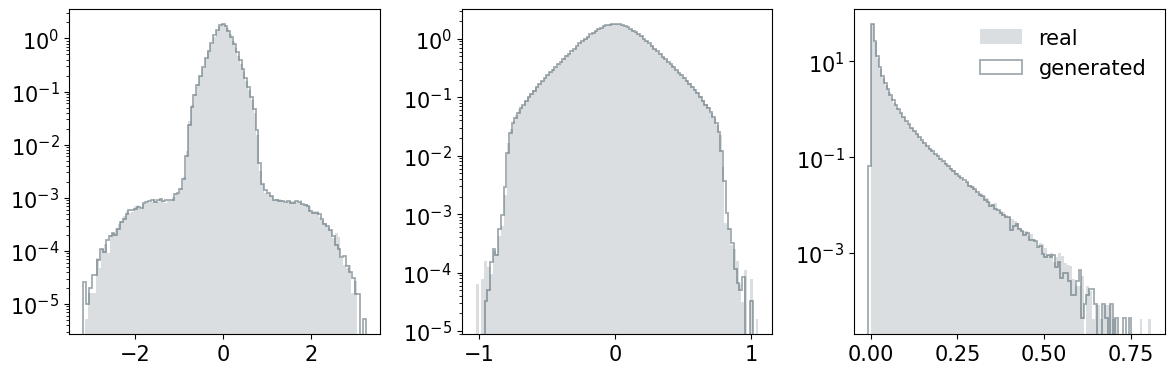

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
hist_kwargs = dict(bins=100, alpha=0.5, density=True)
for i in range(3):
    ax[i].hist(data_real[:, :, i][mask_real[:, :, 0] != 0].flatten(), **hist_kwargs, label="real")
    ax[i].hist(data_generated[:, :, i][mask_real[:, :, 0] != 0].flatten(), **hist_kwargs, label="generated", histtype="step")
    ax[i].set_yscale("log")
ax[2].legend(frameon=False)
fig.tight_layout()

In [11]:
w_dists_big = calculate_all_wasserstein_metrics(
    data_real[..., :3],
    data_generated[..., :3],
    None,
    None,
    num_eval_samples=len(data_real),
    num_batches=factor,
    calculate_efps=True,
    use_masks=False,
)

print(f"W-Dist m: {w_dists_big['w1m_mean']:4.3E} +- {w_dists_big['w1m_std']:4.3E}")
print(f"W-Dist p: {w_dists_big['w1p_mean']:4.3E} +- {w_dists_big['w1p_std']:4.3E}")
print(f"W-Dist efp: {w_dists_big['w1efp_mean']:4.3E} +- {w_dists_big['w1efp_std']:4.3E}")

W-Dist m: 1.496E-03 +- 0.000E+00
W-Dist p: 7.323E-04 +- 0.000E+00
W-Dist efp: 5.004E-04 +- 0.000E+00


In [12]:
w_dists_big_non_averaged = calculate_all_wasserstein_metrics(
    data_real[..., :3],
    data_generated[..., :3],
    None,
    None,
    num_eval_samples=len(data_real),
    num_batches=factor,
    calculate_efps=True,
    use_masks=False,
)
w_dists_big_non_averaged

{'w1m_mean': 0.001533217247823873,
 'w1p_mean': 0.0007093078397800427,
 'w1efp_mean': 0.000516487461166155,
 'w1m_std': 0.0,
 'w1p_std': 0.0,
 'w1efp_std': 0.0}